# Instance Based Learning (K-nearest Neighbors) 

In this notebook, we will use the scikit-learn package to implement a KNN model for car acceptability classification.

### 1. Data Loading and Normalization

We first load the training set and the test set (.NPY files).

In [1]:
import numpy as np
xs_test = np.load('data/xs_test.npy')
xs_train = np.load('data/xs_train.npy')
ys_test = np.load('data/ys_test.npy')
ys_train = np.load('data/ys_train.npy')

What's more, the dictionary files (.CSV) are also loaded.

In [2]:
import csv

att_dic = {}
class_dic = {}

# read the .csv files back to the dictionaries
with open('data/att_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        att_dic[row[0]] = row[1]

with open('data/class_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        class_dic[row[0]] = row[1]


Considering that there is a range of variation in different attributes of the dataset, which can have an impact on the unbiasedness of the distance-based algorithm, we then normalize the data with the formula below:

$X_n=(X-μ_t)/σ_t$ 

Where $X_n$ is the value after normalization, $μ_t$ and $σ_t$ are the mean value and the standard deviation of the training set, respectively.


In [3]:
mu = np.mean(xs_train, axis=0)
sigma = np.std(xs_train, axis=0)

xs_train = (xs_train - mu)/sigma
xs_test = (xs_test - mu)/sigma

### 2. Parameter Tuning

To realise the KNN model, we utilize the KNeighborsClassifier() model of sklearn package to train on our dataset. 

To find a model which fits our data well by hyperparameter tuning, we first check what parameters do KNeighborsClassifier() model have.

According to the output, KNeighborsClassifier() has 8 parameters. Here we only focus on the following three of them:

- <b>n_neighbors:</b> Number of neighbors to use, default value is 5.  


- <b>weights:</b> Weight function used in prediction. Possible values: 

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;  <b>'uniform':</b> uniform weights. All points in each neighborhood are weighted equally. 

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;  <b>'distance':</b> weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. 

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; <b>[callable]:</b> a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.  

- <b>metric:</b> The metric used to evaluate the distance. Possible values: 

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;  <b>'euclidean' :</b> EuclideanDistance.

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp; <b>'manhattan':</b> ManhattanDistance.


In [4]:
# Import KNN model
from sklearn.neighbors import KNeighborsClassifier

# Take a look at which parameters can be tuned
KNN_params = list(KNeighborsClassifier().get_params().keys())
print("Parameters of KNN:", KNN_params)


Parameters of KNN: ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']


Then, we define a dictionary called "param_grid" which contains some possible values of parameters, and use the GridSearchCV() method to train KNN models on each combination of the hyperparameters. In addition, we also do the 5-fold cross validation when tuning the parameters to better estimate the performance of the model on new data.

In [5]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

# Set the range of values of parameters in which we do grid search 
param_grid = [{
    'weights': ["uniform", "distance"],
    'n_neighbors': range(1, 20),
    'metric':['euclidean', 'manhattan', 'cosine']}]

knn_clf = KNeighborsClassifier()
cv = KFold(n_splits=5, shuffle=True, random_state=41)
grid_search = GridSearchCV(knn_clf, param_grid, cv=cv, scoring="f1_weighted", verbose=0)
grid_search.fit(xs_train, ys_train.ravel())


GridSearchCV(cv=KFold(n_splits=5, random_state=41, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['euclidean', 'manhattan', 'cosine'],
                          'n_neighbors': range(1, 20),
                          'weights': ['uniform', 'distance']}],
             scoring='f1_weighted')

By outputting the best estimator of the grid search, we can see that when setting metirc as 'enclidean', n-neighbors=8 and weights='distance', the KNN classifier gets the best weighted F1 score in the validation.

In [6]:
# output the best combination of parameters
for param in grid_search.best_params_:
    print('Best', param, ':',grid_search.best_params_[param])

Best metric : euclidean
Best n_neighbors : 8
Best weights : distance


To visualize the process of parameter tuning, setting weight='distance', we plot the line chart of weighted F1 score with respect to the number of neighbors (n_neighbors) in different metric settings. 

The chart verifies that when the metirc and n_neighbor are set as 'enclidean' and 8, the weighted F1 score reaches the peak in the cross validation.

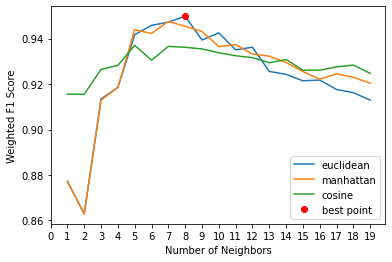

In [7]:
import matplotlib.pyplot as plt

mean_score = grid_search.cv_results_['mean_test_score']

# print(grid_search.cv_results_)
f1_euclidean = [None]
f1_manhattan = [None]
f1_cosine = [None]

# append the weighted F1 score in different n_neighbor settings to three list
for i in range(len(mean_score)):
    if grid_search.cv_results_['param_metric'][i] == 'euclidean' and grid_search.cv_results_['param_weights'][i] == 'distance':
        f1_euclidean.append(mean_score[i])
    elif grid_search.cv_results_['param_metric'][i] == 'manhattan' and grid_search.cv_results_['param_weights'][i] == 'distance':
        f1_manhattan.append(mean_score[i])
    elif grid_search.cv_results_['param_metric'][i] == 'cosine' and grid_search.cv_results_['param_weights'][i] == 'distance':
        f1_cosine.append(mean_score[i])
        
# plot line chart
plt.plot(f1_euclidean, label='euclidean')
plt.plot(f1_manhattan, label='manhattan')
plt.plot(f1_cosine, label='cosine')

# plot the point with the biggest F1 score
if grid_search.best_params_['metric'] == 'euclidean':
    best_f1 = f1_euclidean[grid_search.best_params_['n_neighbors']]
elif grid_search.best_params_['metric'] == 'manhattan':
    best_f1 = f1_manhattan[grid_search.best_params_['n_neighbors']]
elif grid_search.best_params_['metric'] == 'cosine':
    best_f1 = f1_cosine[grid_search.best_params_['n_neighbors']]
plt.plot(grid_search.best_params_['n_neighbors'],best_f1,'ro',label='best point')

# set the lable of the graph
plt.xlabel('Number of Neighbors')
plt.ylabel('Weighted F1 Score')
plt.xticks(np.arange(0,20,1))
# plot the legend of the graph
plt.legend(loc='lower right')

plt.show()

### 3. Model Training and Evaluation

Then, using the best combination of hyperparameters output by the grid search, we construct and train a KNN classifier on the training set.

In [8]:
# Best Model: metric='euclidean', n_neighbors=8, weights='distance'
knn_clf = KNeighborsClassifier(metric='euclidean', n_neighbors=8, weights='distance')
knn_clf.fit(xs_train, ys_train.ravel())

KNeighborsClassifier(metric='euclidean', n_neighbors=8, weights='distance')

In order to use the trained model again in the Model Ensemble Part, we save the model with joblib() method in sklearn.

In [9]:
import joblib
# save the trained KNN model
joblib.dump(knn_clf, 'models/Instance_Based_KNN.model')

['models/Instance_Based_KNN.model']

Finally, we evaluate the KNN model by making classification reports both on the traing set and on the test set.

In [10]:
from sklearn.metrics import classification_report

# predict the ys with xs of training set and test set
ys_train_pred = knn_clf.predict(xs_train)
ys_test_pred = knn_clf.predict(xs_test)

# print the classfication report
print('Classification Report of KNN on the Training set: \n\n',
      classification_report(ys_train, ys_train_pred, digits=4))
print('Classification Report of KNN on the Test set: \n\n',
      classification_report(ys_test, ys_test_pred, digits=4))

Classification Report of KNN on the Training set: 

               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       968
           1     1.0000    1.0000    1.0000       307
           2     1.0000    1.0000    1.0000        52
           3     1.0000    1.0000    1.0000        55

    accuracy                         1.0000      1382
   macro avg     1.0000    1.0000    1.0000      1382
weighted avg     1.0000    1.0000    1.0000      1382

Classification Report of KNN on the Test set: 

               precision    recall  f1-score   support

           0     0.9798    1.0000    0.9898       242
           1     0.9863    0.9351    0.9600        77
           2     1.0000    0.7692    0.8696        13
           3     0.8750    1.0000    0.9333        14

    accuracy                         0.9769       346
   macro avg     0.9603    0.9261    0.9382       346
weighted avg     0.9777    0.9769    0.9763       346



We also plot a Confusion Matrix Heatmap by using the seaborn package in order to better present the classification results.

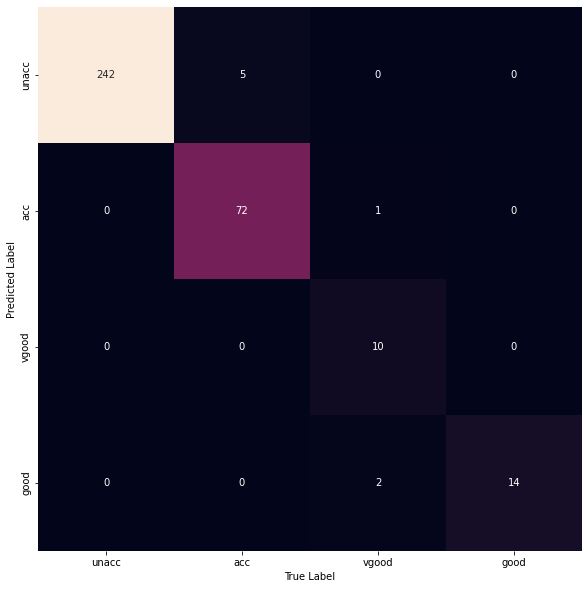

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# construct a confusion matrix which shows the accuracy on each class
mat = confusion_matrix(ys_test, ys_test_pred)

# plot the confusion matrix into a heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_dic.values(), yticklabels=class_dic.values())
# set the x and y label of the figure
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()
